In [3]:
from glob import glob
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.signal import spectrogram, find_peaks
from music21 import pitch
import soundfile as sf

# Working with data: CA2
by Jonas Wortmann
## Dataset
The dataset contains piano and guitar recordings and was scraped from various sources. Each recording contains a chord and is labelled by its corresponding tuning, if it's a major or minor chord. You find the data freely available on [kaggle](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification/data).
## 1. Import and Pre-processing

In [4]:
major_dir = "data/Audio_Files/Major/*.wav"
minor_dir = "data/Audio_Files/Minor/*.wav"
maj_files = glob(major_dir)
min_files = glob(minor_dir)
all_files = [*maj_files, *min_files]
len(all_files)

859

In [5]:
def is_stereo(y: np.array):
    is_stereo = y.ndim == 2

    if is_stereo:
        return "Stereo"
    else:
        return "Mono"
    

In [6]:
def load_audio(file_row):
    y, sample_rate = librosa.load(file_row['fname'], sr=None, mono=False)
    return pd.Series([y, sample_rate], index=['y', 'sample_rate'])

df = pd.DataFrame({'fname': maj_files + min_files, 
                   'chord_type': ['maj']*len(maj_files) + ['min']*len(min_files)})

df[['y', 'sample_rate']] = df.apply(load_audio, axis=1)
df["channel_type"] = df.y.apply(is_stereo)

The audio files are read by librosa's load function. By setting `sr` = None the native sampling rate of the file is used, in this case 44,100 Hz. To prevent Librosa to automatically convert the audio from stereo to mono, `mono` is set to False. The load function also normalizes the audio to the sample values between -1 and 1. \
To identify whether the audio is mono or stereo, each numpy array that represents the audio in the time domain, is checked if it consists of two (stereo) dimensions.

Text(0.5, 1.0, 'Trimmed Signal')

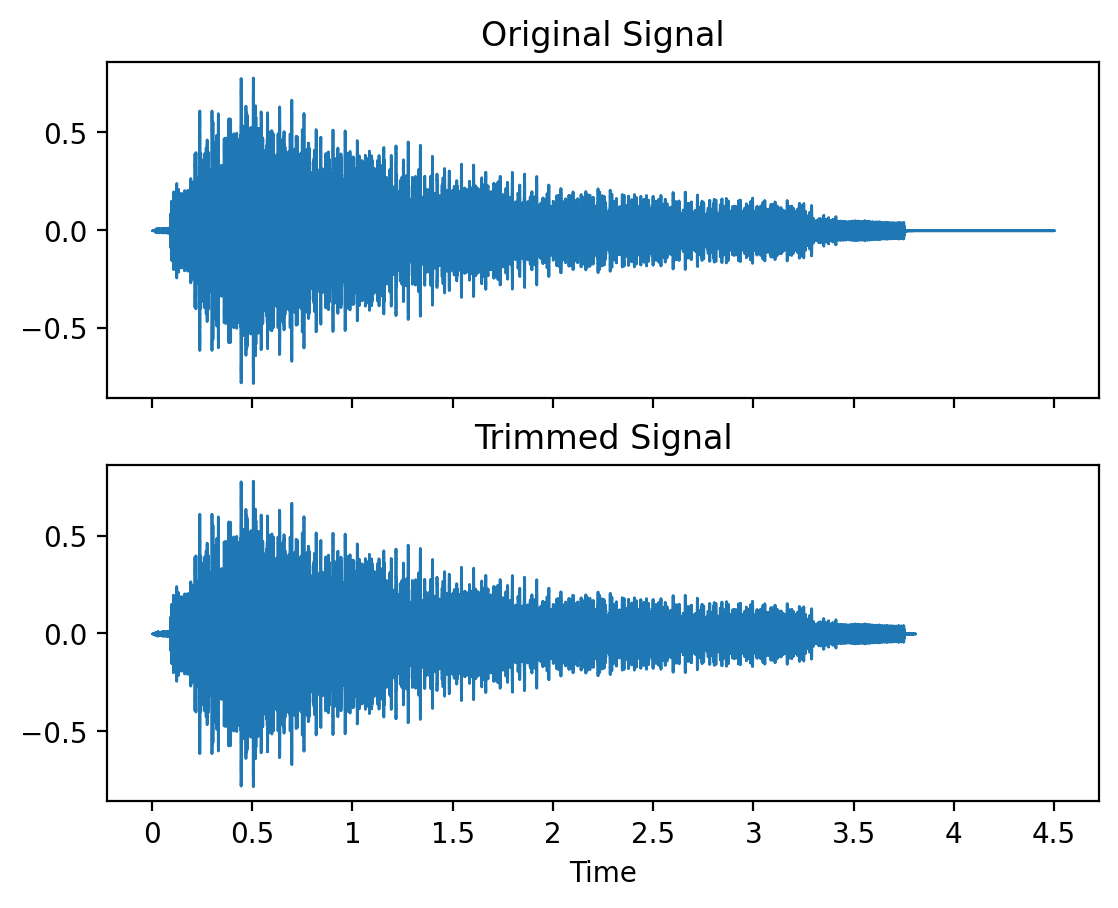

In [7]:
def trim_audio(y):
    trimmed_y, _ = librosa.effects.trim(y)
    return trimmed_y

df["trimmed_y"] = df.y.apply(trim_audio)

fig, ax = plt.subplots(2,1, sharex=True)
librosa.display.waveshow(df.loc[1,"y"], ax=ax[0])
ax[0].set_title("Original Signal")
ax[0].set_xlabel("")
librosa.display.waveshow(df.loc[1,"trimmed_y"], ax=ax[1])
ax[1].set_title("Trimmed Signal")

By trimming the audio, the start and end of a signal with an amplitude of 0 is removed, as you can see at the above plots. The standard threshold of librosa is -60 db, so everything below -60 db is considered as silence.

## 2. Statistics and characteristics

In [8]:
df.channel_type.value_counts()

channel_type
Mono    859
Name: count, dtype: int64

In [9]:
df.sample_rate.value_counts()

sample_rate
44100    859
Name: count, dtype: int64

In [10]:
# Use soundfile to get the bit depth
def get_bitdepth(file_path):
    info = sf.info(file_path)
    bit_depth = info.subtype
    return bit_depth

df["bit_depth"] = df.fname.apply(get_bitdepth)
df.bit_depth.value_counts()

bit_depth
PCM_16    859
Name: count, dtype: int64

The following features could be extracted for the entire dataset:
- channel type: Mono
- sample rate: 44,100 Hz
- bit depth: 16 bit

Next, the root mean square (RMS) is calculated. Librosa natively calculates the RMS for each frame so to compare the recordings, the mean of all rms is calculated. In the following code, this is carried out with both the original signal and the trimmed signal.

Text(0.5, 0, 'RMS')

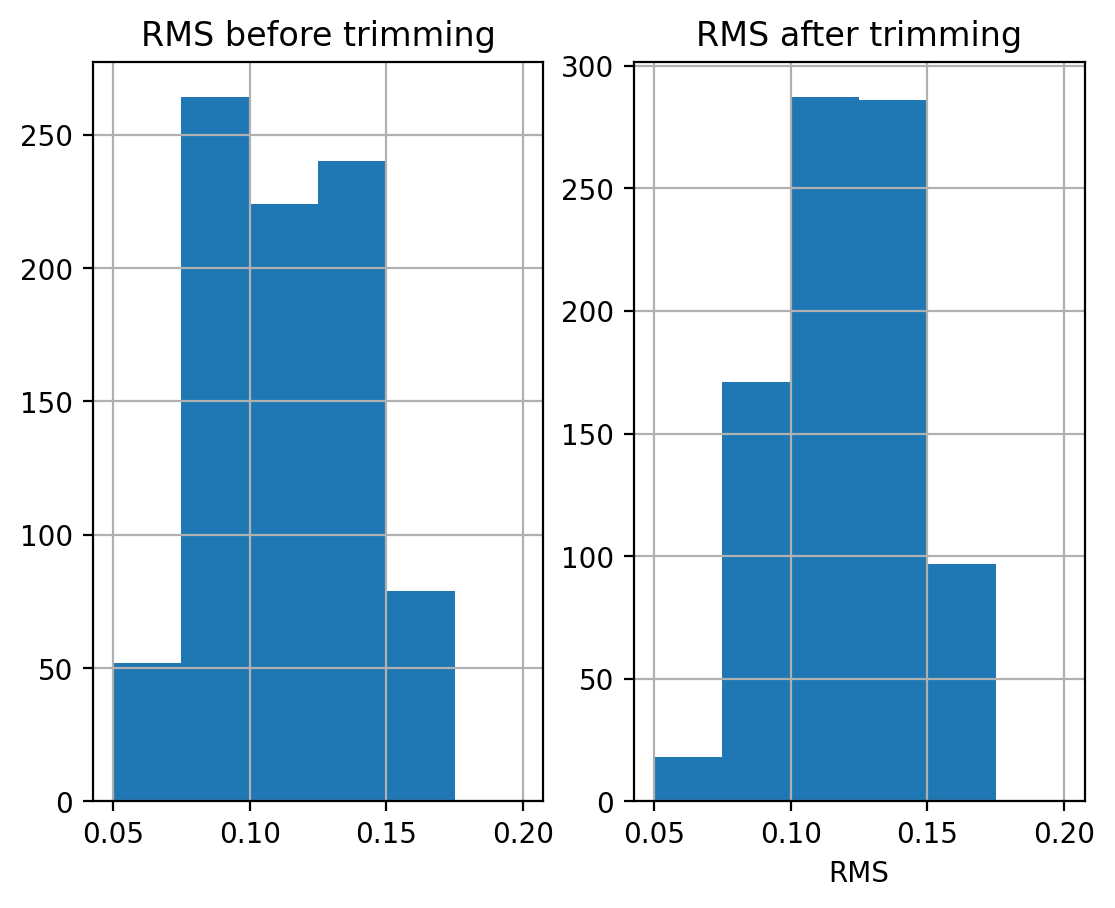

In [11]:
df["rms"] = df.trimmed_y.apply(lambda y: librosa.feature.rms(y=y)[0]) #calculate rms for each frame and each recording
df["rms_mean"] = df["rms"].apply(np.mean) # calculate the mean of all frames for each recording
fig, ax = plt.subplots(1,2)
bins=[0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
df.rms_mean.hist(ax=ax[1], bins=bins)
df.y.apply(lambda y: librosa.feature.rms(y=y)[0]).apply(np.mean).hist(ax=ax[0], bins=bins)
ax[1].set_title("RMS after trimming")
ax[0].set_title("RMS before trimming")
plt.xlabel("RMS")

The RMS is comparatively higher in the trimmed signal, because the silence is removed before and after the chord is played.

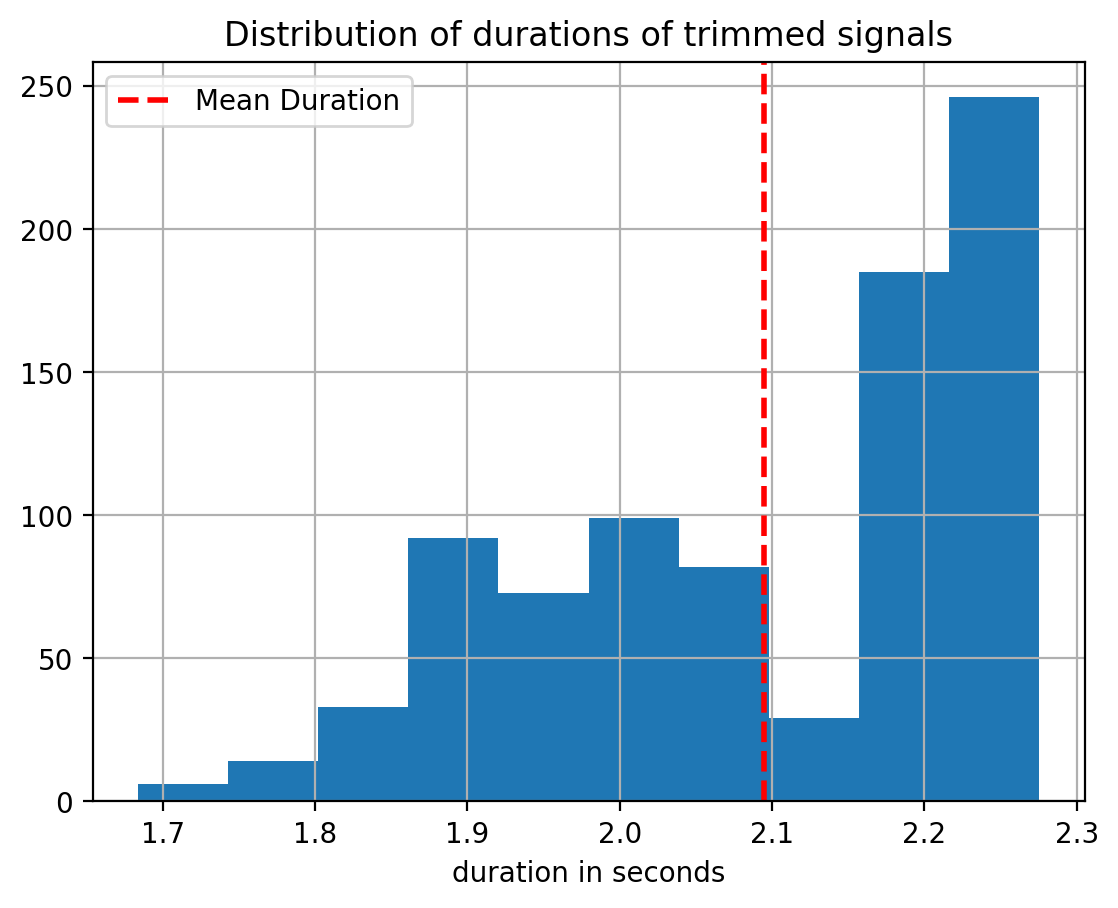

In [12]:
sr = 44100
df['duration'] = df.trimmed_y.apply(lambda y: librosa.get_duration(y=y, sr=sr))
df.duration.hist()
plt.xlabel("duration in seconds")
plt.title("Distribution of durations of trimmed signals")
# Add a vertical line representing the mean duration
mean_duration = df['duration'].mean()
plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=2, label='Mean Duration')
plt.legend()
plt.show()

The mean recording duration is at 2.1 seconds while the duration ranges between 1.7 and 2.3 seconds.

<Axes: title={'center': 'Number of minor and major samples'}, xlabel='chord_type'>

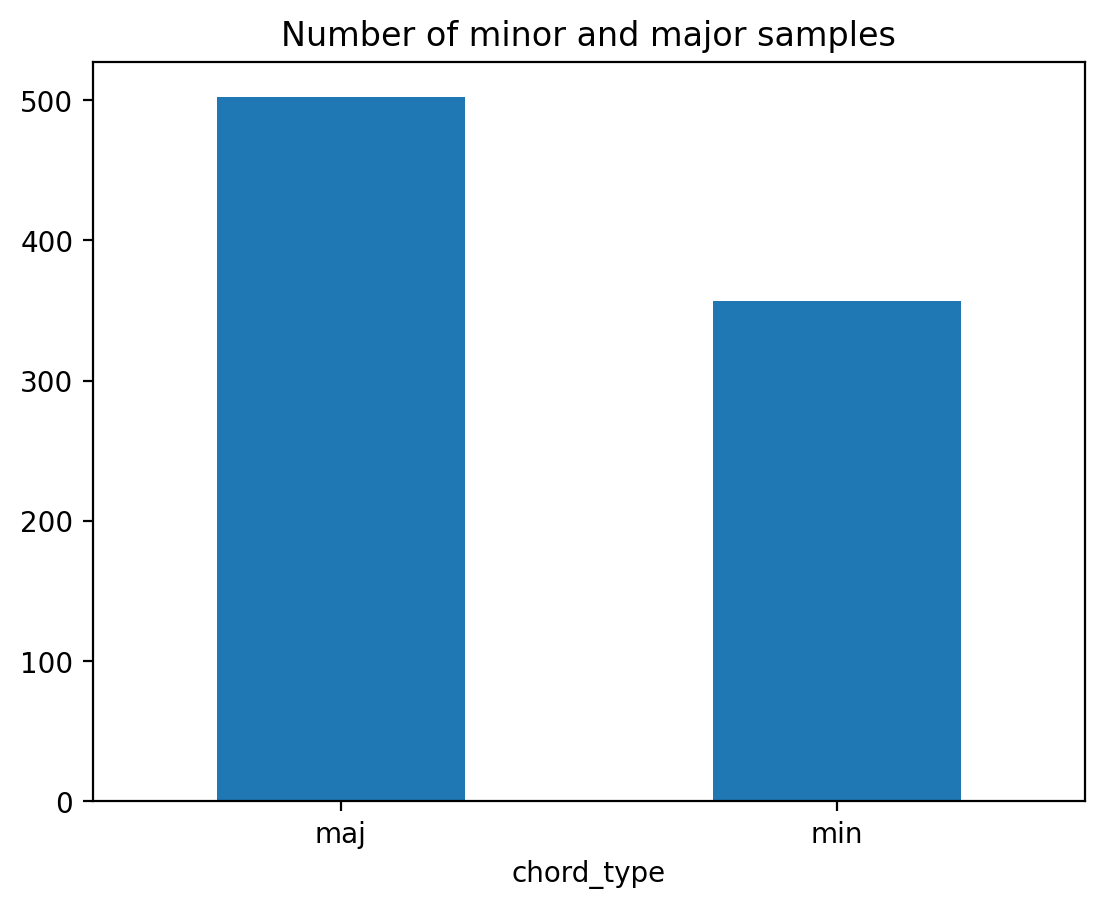

In [13]:
minor = df["chord_type"] == "min"
major = df["chord_type"] == "maj"
df.chord_type.value_counts().plot(kind="bar", title="Number of minor and major samples", rot=0)

## 3. Visualisations and patterns in the data

### Fast Fourier Transform (FFT)
By conducting the Fast Fourier Transform, the signal can be converted from the time domain into the frequency domain. FFT is able to decompose the actual chord into their component frequencies. This section attempts to decompose each audio by using FFT to identify the actual chord being played. To validate the results, the first five major chords are labelled using Ableton Live's audio to MIDI converter. There you can see, the chord consists of up to five individual notes. Nevertheless, there is no guarantee that the audio MIDI converter will work perfectly and that the labelling will be 100% correct, but it does have a reputation for being very precise. 

In [22]:
maj_0 = ["C2", "E2", "G2", "C3", "E3"] # C maj
maj_1 = ["C2", "E2", "G2"] # C maj
maj_2 = ["C2", "G2", "C3", "E3", "A3"] # C maj 9
maj_3 = maj_2
maj_4 = ["C2", "E2", "A2", "C3", "D3"] # C maj 6
df.loc[:4,"chord_labels"] = pd.Series([maj_0, maj_1, maj_2, maj_3, maj_4])
df.head()

,fname,chord_type,y,sample_rate,channel_type,trimmed_y,bit_depth,rms,rms_mean,duration,chord_labels
0,data/Audio_Files/Major\Major_0.wav,maj,"[-0.004333496, -0.0058898926, -0.0048217773, -...",44100,Mono,"[-0.004333496, -0.0058898926, -0.0048217773, -...",PCM_16,"[0.09400184, 0.11899431, 0.13773252, 0.1489178...",0.130229,2.229116,"[C2, E2, G2, C3, E3]"
1,data/Audio_Files/Major\Major_1.wav,maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,Mono,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",PCM_16,"[0.0041447324, 0.005810158, 0.012264813, 0.050...",0.120714,1.904036,"[C2, E2, G2]"
2,data/Audio_Files/Major\Major_10.wav,maj,"[-0.004333496, -0.0058898926, -0.0048217773, -...",44100,Mono,"[-0.004333496, -0.0058898926, -0.0048217773, -...",PCM_16,"[0.09400184, 0.11899431, 0.1377317, 0.15422438...",0.134003,2.182676,"[C2, G2, C3, E3, A3]"
3,data/Audio_Files/Major\Major_100.wav,maj,"[-0.0062561035, -0.008087158, -0.007171631, -0...",44100,Mono,"[-0.0062561035, -0.008087158, -0.007171631, -0...",PCM_16,"[0.09224215, 0.112823814, 0.1325439, 0.1449561...",0.117118,2.182676,"[C2, G2, C3, E3, A3]"
4,data/Audio_Files/Major\Major_101.wav,maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,Mono,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",PCM_16,"[0.0075093084, 0.010084022, 0.018206747, 0.067...",0.108137,1.869206,"[C2, E2, A2, C3, D3]"


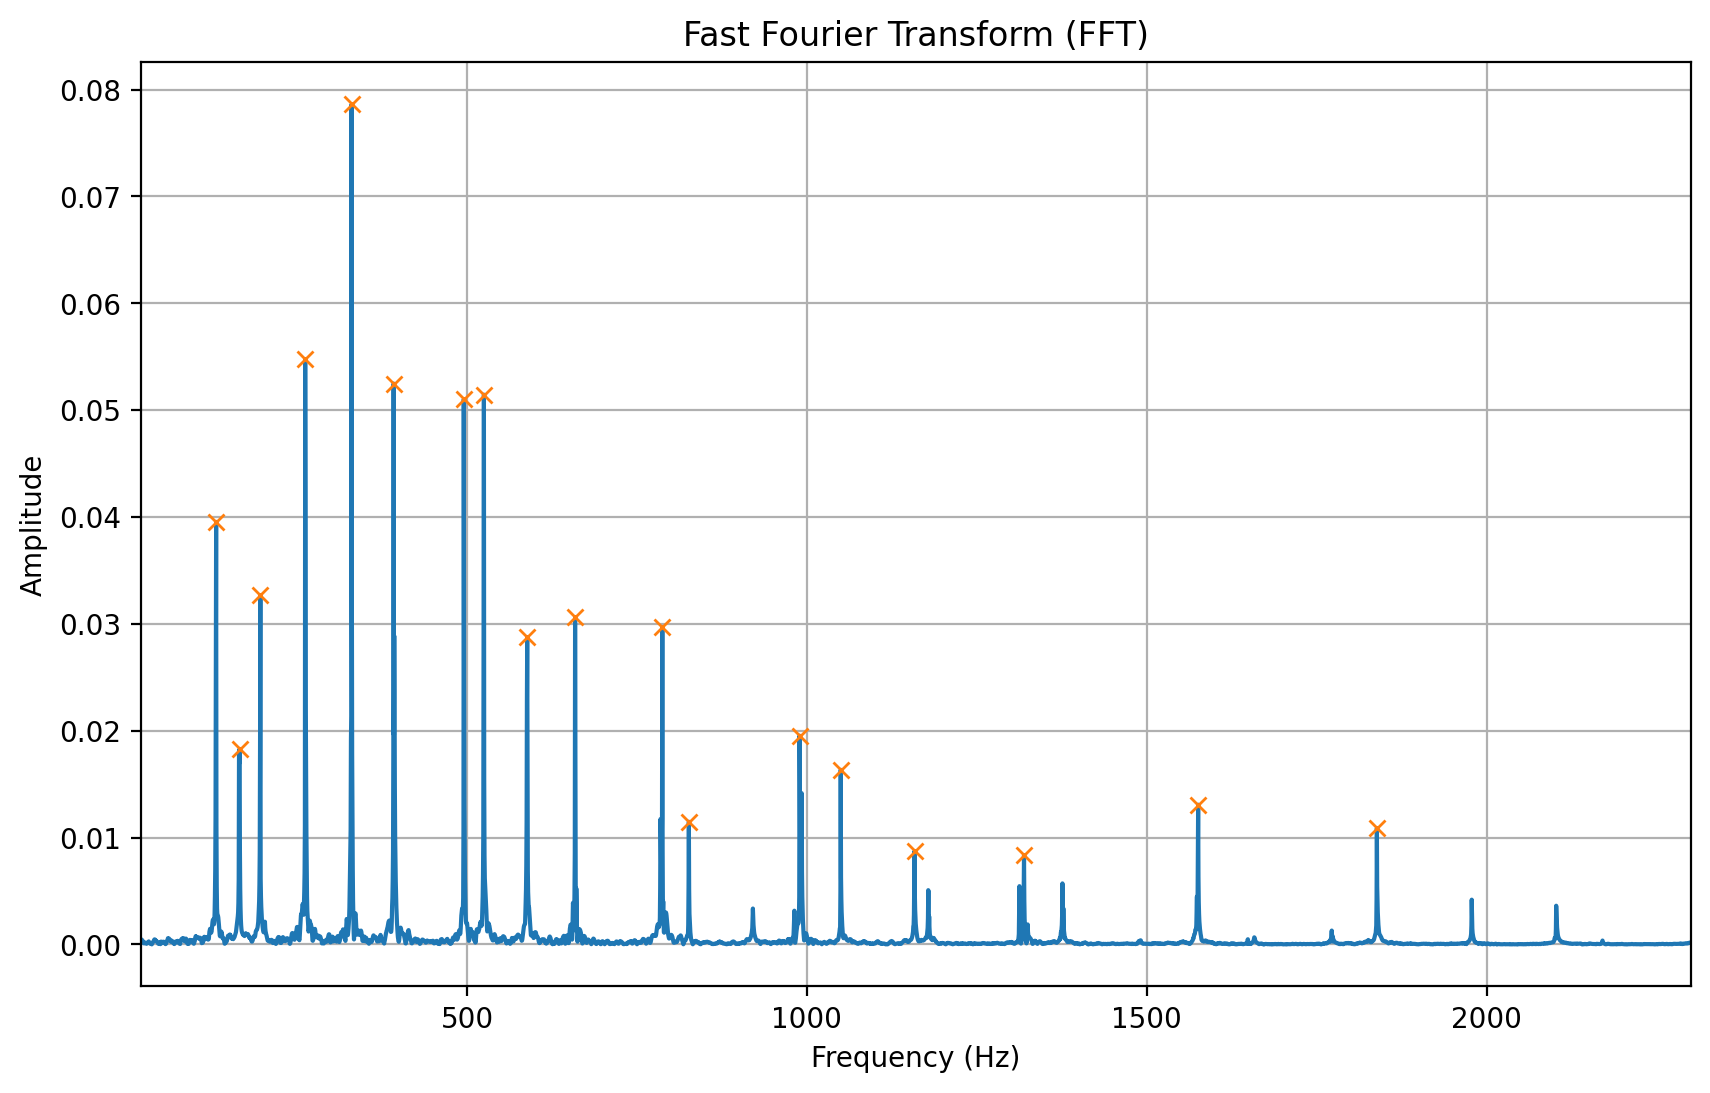

Detected peaks:  18


In [14]:
y = df.loc[0,"trimmed_y"]
fs = df.loc[0, "sample_rate"]
N = len(y)
y_freq = np.fft.fftfreq(N, 1/fs)[:N//2]  # array for frequency stamps
signal_f = np.fft.fft(y) # Signal in frequency domain
signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # taking positive terms

h = signal_f_onesided.max()*10/100 # the amplitude must be 10% of the maximum value to detect them as peak
peaks, peak_heights = find_peaks(signal_f_onesided, distance=10, height = h) 
harmonics = y_freq[peaks]
harmonics_round = np.round(harmonics)


plt.figure(figsize=(10, 6))
plt.plot(y_freq, signal_f_onesided)
plt.title('Fast Fourier Transform (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim((20,2300))
plt.grid(True)
plt.plot(harmonics,peak_heights["peak_heights"], "x")
plt.show()
print("Detected peaks: ", len(peaks))

The line plot shows the FFT's outcome with their respective peaks. To find each peak the local maxima are calculated, by simply comparing them with their neighbouring values (marked as orange "x" in the plot). \
18 peak frequencies are detected. Since this allows a lot of interpretation to identify the played chord, the number of peaks are reduced to the top five so the results are comparable to the labels.

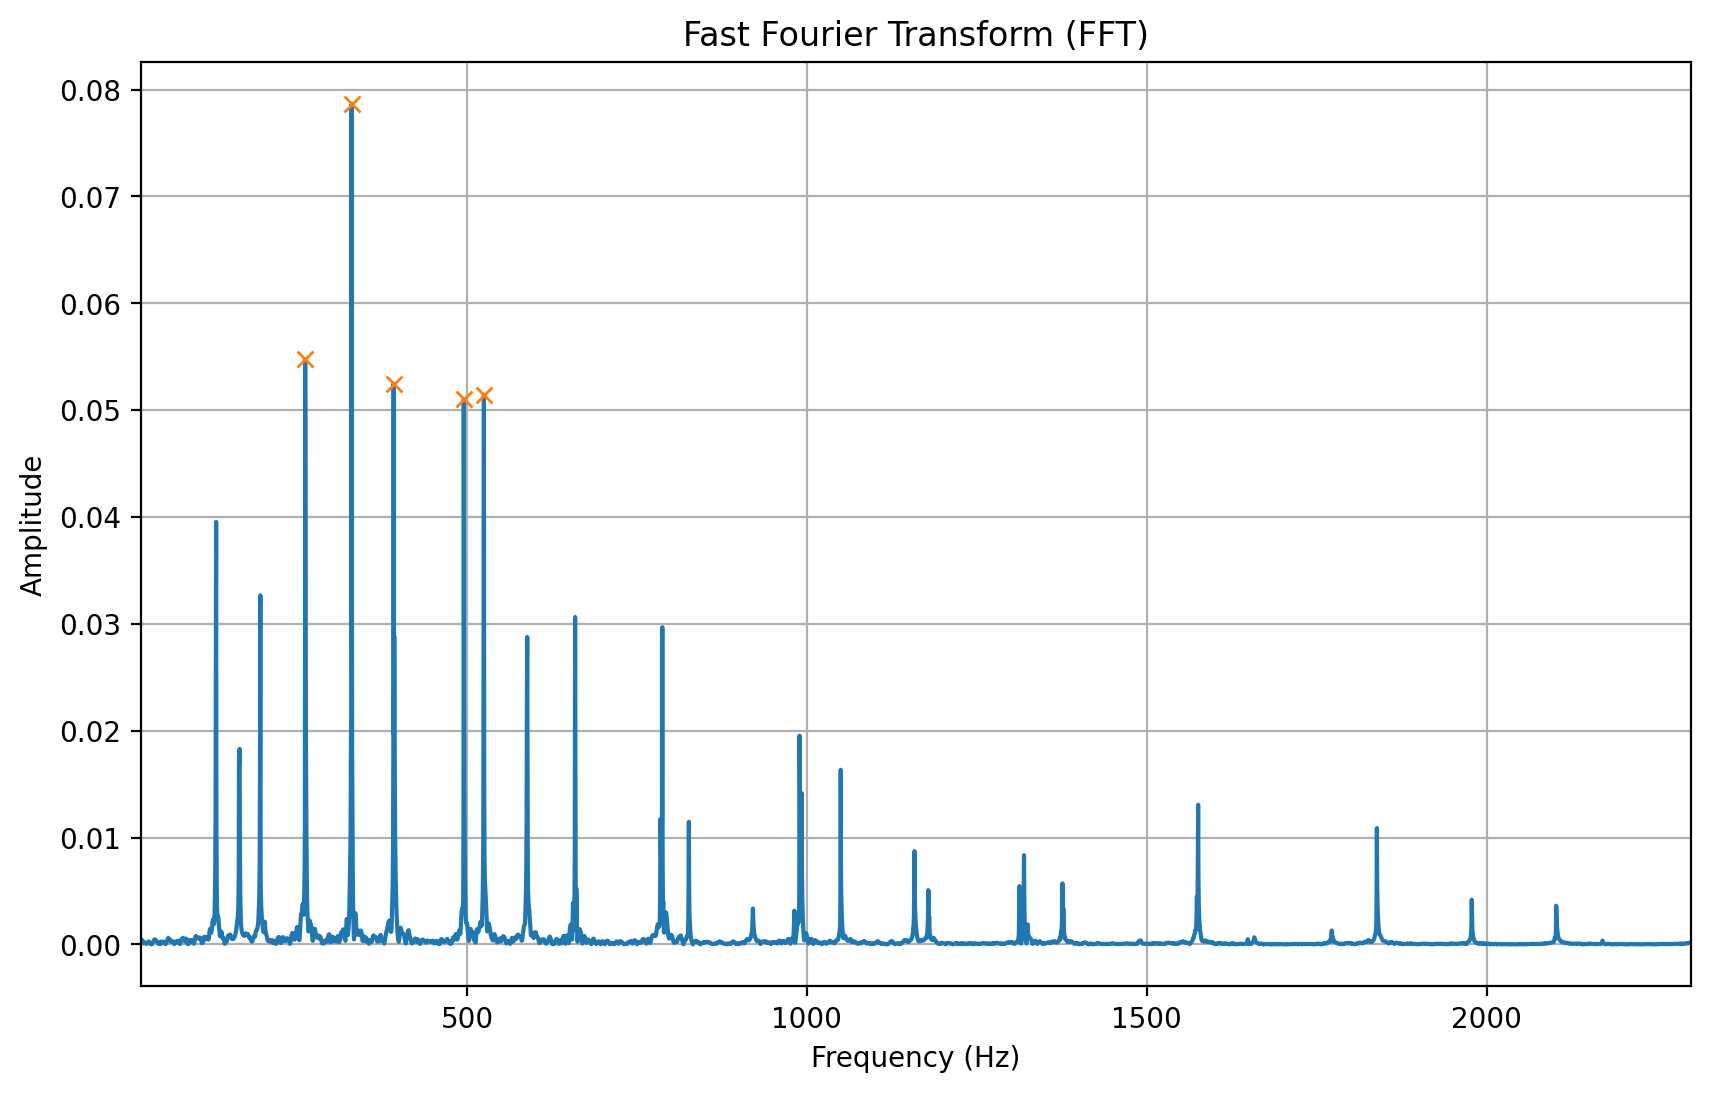

In [23]:
highest_values_indices = np.argsort(peak_heights['peak_heights'])[-5:]
highest_peak_frequencies = y_freq[peaks[highest_values_indices]]

plt.figure(figsize=(10, 6))
plt.plot(y_freq, signal_f_onesided)
plt.title('Fast Fourier Transform (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim((20,2300))
plt.grid(True)
plt.plot(highest_peak_frequencies,peak_heights["peak_heights"][highest_values_indices], "x")
plt.show()

Next the frequencies are transformed into musical notes by using music21's Pitch method.

In [33]:
def frequency_to_note(frequency):
    midi_note = pitch.Pitch()
    midi_note.frequency = frequency
    return midi_note.nameWithOctave

# sort frequencies ascending in a ascending order
highest_peak_frequencies = np.sort(highest_peak_frequencies)
for freq in highest_peak_frequencies:
    musical_note = frequency_to_note(freq)
    print(f"The frequency {freq} Hz corresponds to the musical note: {musical_note}")


The frequency 261.9873046875 Hz corresponds to the musical note: C4
The frequency 330.17578125 Hz corresponds to the musical note: E4
The frequency 392.083740234375 Hz corresponds to the musical note: G4
The frequency 495.263671875 Hz corresponds to the musical note: B4
The frequency 524.871826171875 Hz corresponds to the musical note: C5


In [34]:
df.loc[0, "chord_labels"]

['C2', 'E2', 'G2', 'C3', 'E3']

The peaks with the highest amplitudes are G4, C4, and E4. These notes build a C major chord. As you can see the lower notes C2 and E2 are not detected and B4 is detected but is not part of the C major chord. \
Next, for each signal the musical notes are detected.

In [36]:
def detect_musical_notes(row, nr_notes):
    y = row["trimmed_y"]
    fs = row["sample_rate"]
    N = len(y)
    y_freq = np.fft.fftfreq(N, 1/fs)[:N//2]  # array for frequency stamps
    signal_f = np.fft.fft(y) # Signal in frequency domain
    signal_f_onesided = 2.0/N * np.abs(signal_f[0:N//2]) # taking positive terms

    h = signal_f_onesided.max()*10/100
    peaks, peak_heights = find_peaks(signal_f_onesided, distance=10, height = h) #threshold=threshold
    harmonics = y_freq[peaks]
    harmonics_round = np.round(harmonics)
    highest_values_indices = np.argsort(peak_heights['peak_heights'])[-nr_notes:]
    highest_peak_frequencies = y_freq[peaks[highest_values_indices]]

    detected_notes = []
    highest_peak_frequencies = np.sort(highest_peak_frequencies)
    for freq in highest_peak_frequencies:
        musical_note = frequency_to_note(freq)
        detected_notes.append(musical_note)

    return detected_notes

df["musical_notes"] = df.apply(detect_musical_notes,nr_notes=5, axis=1)    

In [39]:
df.loc[:, ["musical_notes", "chord_labels"]].head(5)

,musical_notes,chord_labels
0,"[C4, E4, G4, B4, C5]","[C2, E2, G2, C3, E3]"
1,"[E3, G3, C4, G4, B4]","[C2, E2, G2]"
2,"[F#3, B-3, C4, F#4, B-4]","[C2, G2, C3, E3, A3]"
3,"[C#4, D#4, G4, B-4, C#5]","[C2, G2, C3, E3, A3]"
4,"[E-3, G3, C#4, E-4, F4]","[C2, E2, A2, C3, D3]"


The first major chord is a C as discussed above. The second chord is an C maj as well and was detected correctly except the B4. This might be caused by the 5-note threshold which was set above. The third, fourth and fifth chord weren't properly detected. As they include the 9th and 6th note respectively and therefore have a disharmonic sound, they might be harder to detect. Listen to the following audios to hear the disharmony in the chords.

In [42]:
ipd.Audio(df.loc[2, "trimmed_y"], rate=df.loc[2, "sample_rate"]) # C 9

In [44]:
ipd.Audio(df.loc[4, "trimmed_y"], rate=df.loc[4, "sample_rate"]) # C 6

The result shows challenges in decomposing chords into their musical notes by just using FFT. It is more complex and probably needs more post-processing to find the actual musical notes.

### Spectrogram

To put the time domain and frequency domain together, a spectrogram is used to visualise the signal over time at various frequencies. A spectrogram also makes use of the Fast-Fourier-Transform to analyse the frequency spectrum. In the result you see the frequencies with the highest amplitude in red, the lowest in blue. Since most frequencies are below 2.5 kHz a zoomed spectrogram gives a detailed insight into the frequency distribution. As each audio consists only of one chord, you can see how long each frequency sustains and how it fades over time.

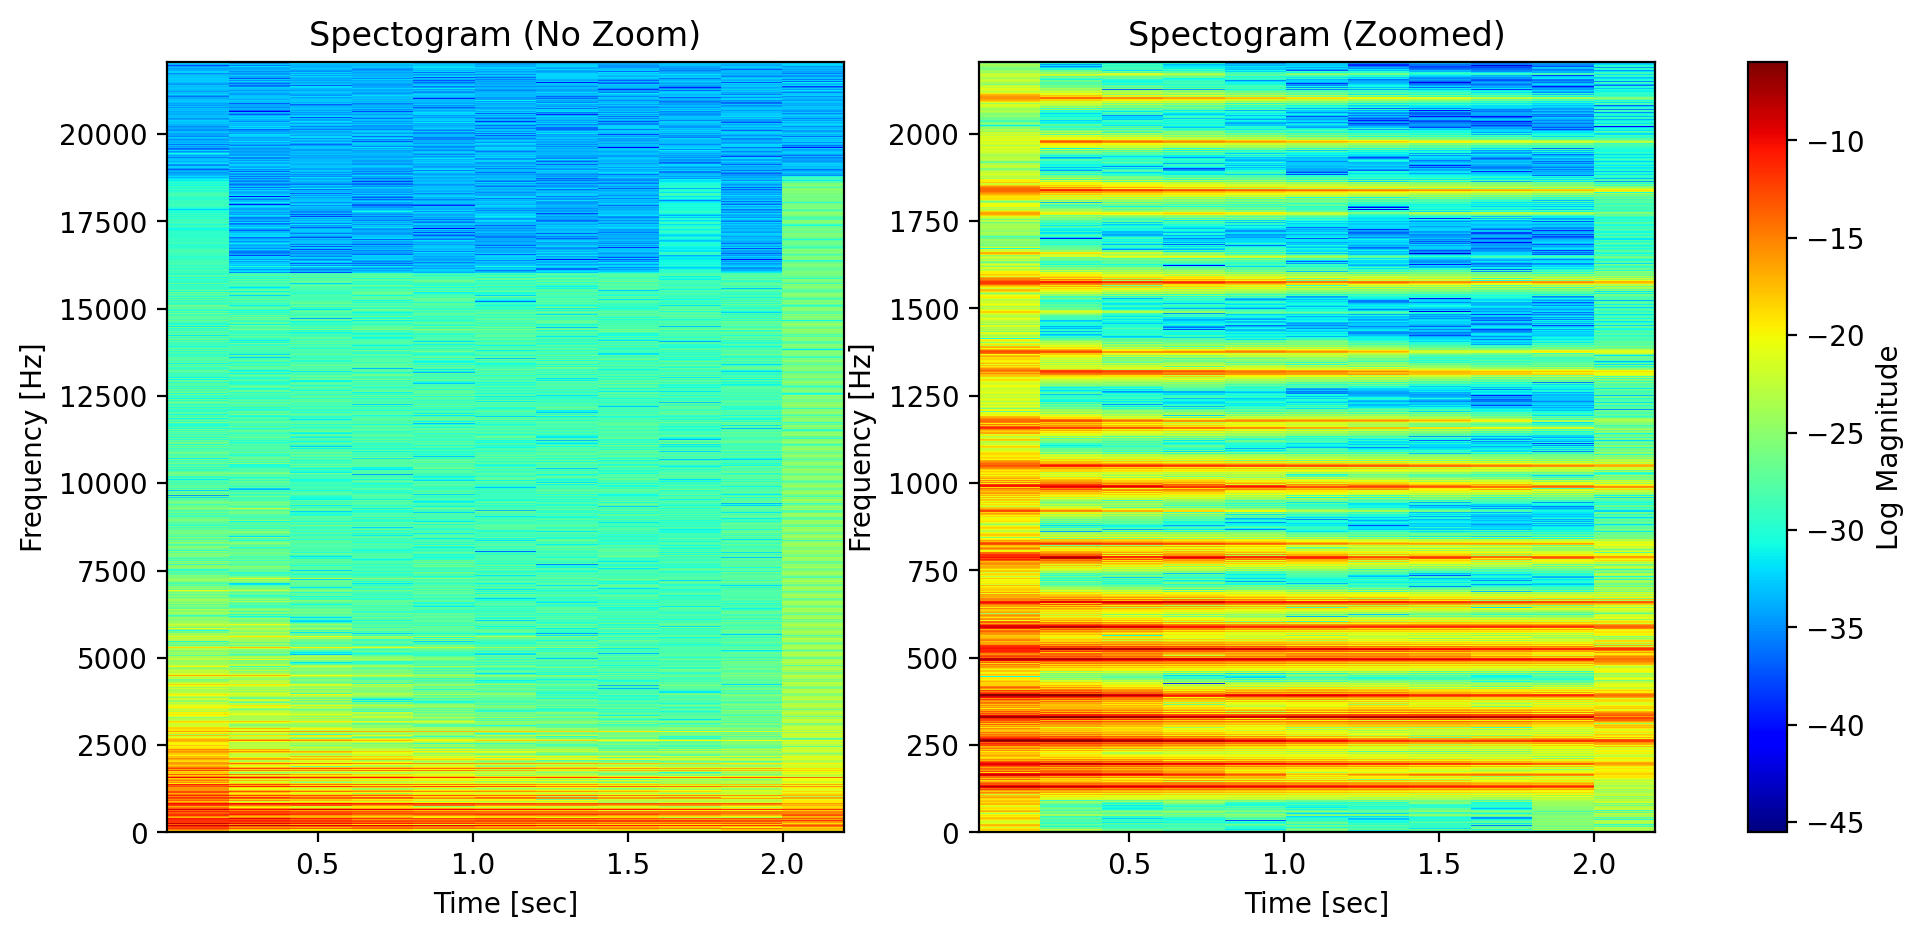

In [72]:
f, t, Sxx = spectrogram(y, fs, nperseg=10000, nfft = 50000)


# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
pcm1 = axes[0].pcolormesh(t, f, np.log(Sxx), cmap="jet")

axes[0].pcolormesh(t, f, np.log(Sxx), cmap="jet")
axes[0].set_title("Spectogram (No Zoom)")
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t, f[:2500], np.log(Sxx)[:2500,:], cmap="jet")
axes[1].set_title("Spectogram (Zoomed)")
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
cbar = fig.colorbar(pcm1, ax=axes, label='Log Magnitude')

plt.show()

Since the dataset contains both piano and guitar recordings, spectrograms for both instruments are compared.

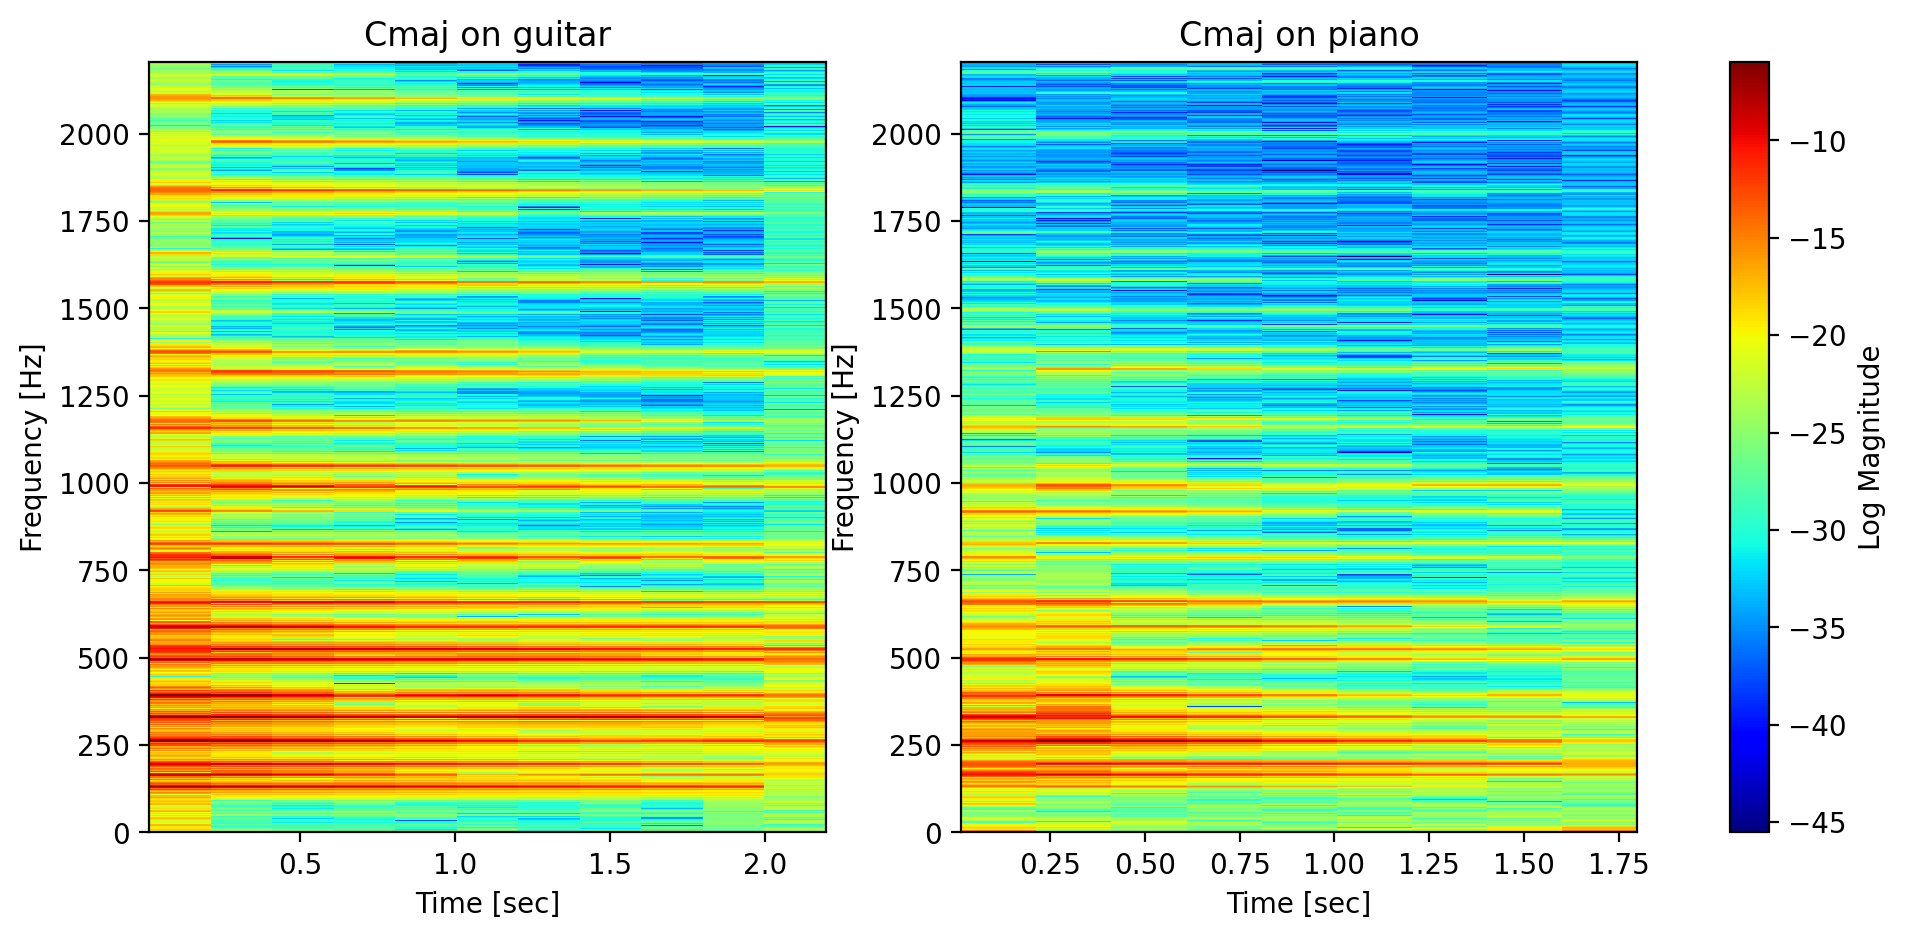

In [73]:
guitar = df.loc[0,"trimmed_y"]
piano = df.loc[1, "trimmed_y"]
fs = df.loc[0, "sample_rate"]

f_g, t_g, Sxx_g = spectrogram(guitar, fs, nperseg=10000, nfft = 50000)
f_p, t_p, Sxx_p = spectrogram(piano, fs, nperseg=10000, nfft = 50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pcolormesh(t_g, f_g[:2500], np.log(Sxx_g)[:2500], cmap="jet")
axes[0].set_title("Cmaj on guitar")
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t_p, f_p[:2500], np.log(Sxx_p[:2500]), cmap="jet")
axes[1].set_title("Cmaj on piano")
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
cbar = fig.colorbar(pcm1, ax=axes, label='Log Magnitude')

plt.show()

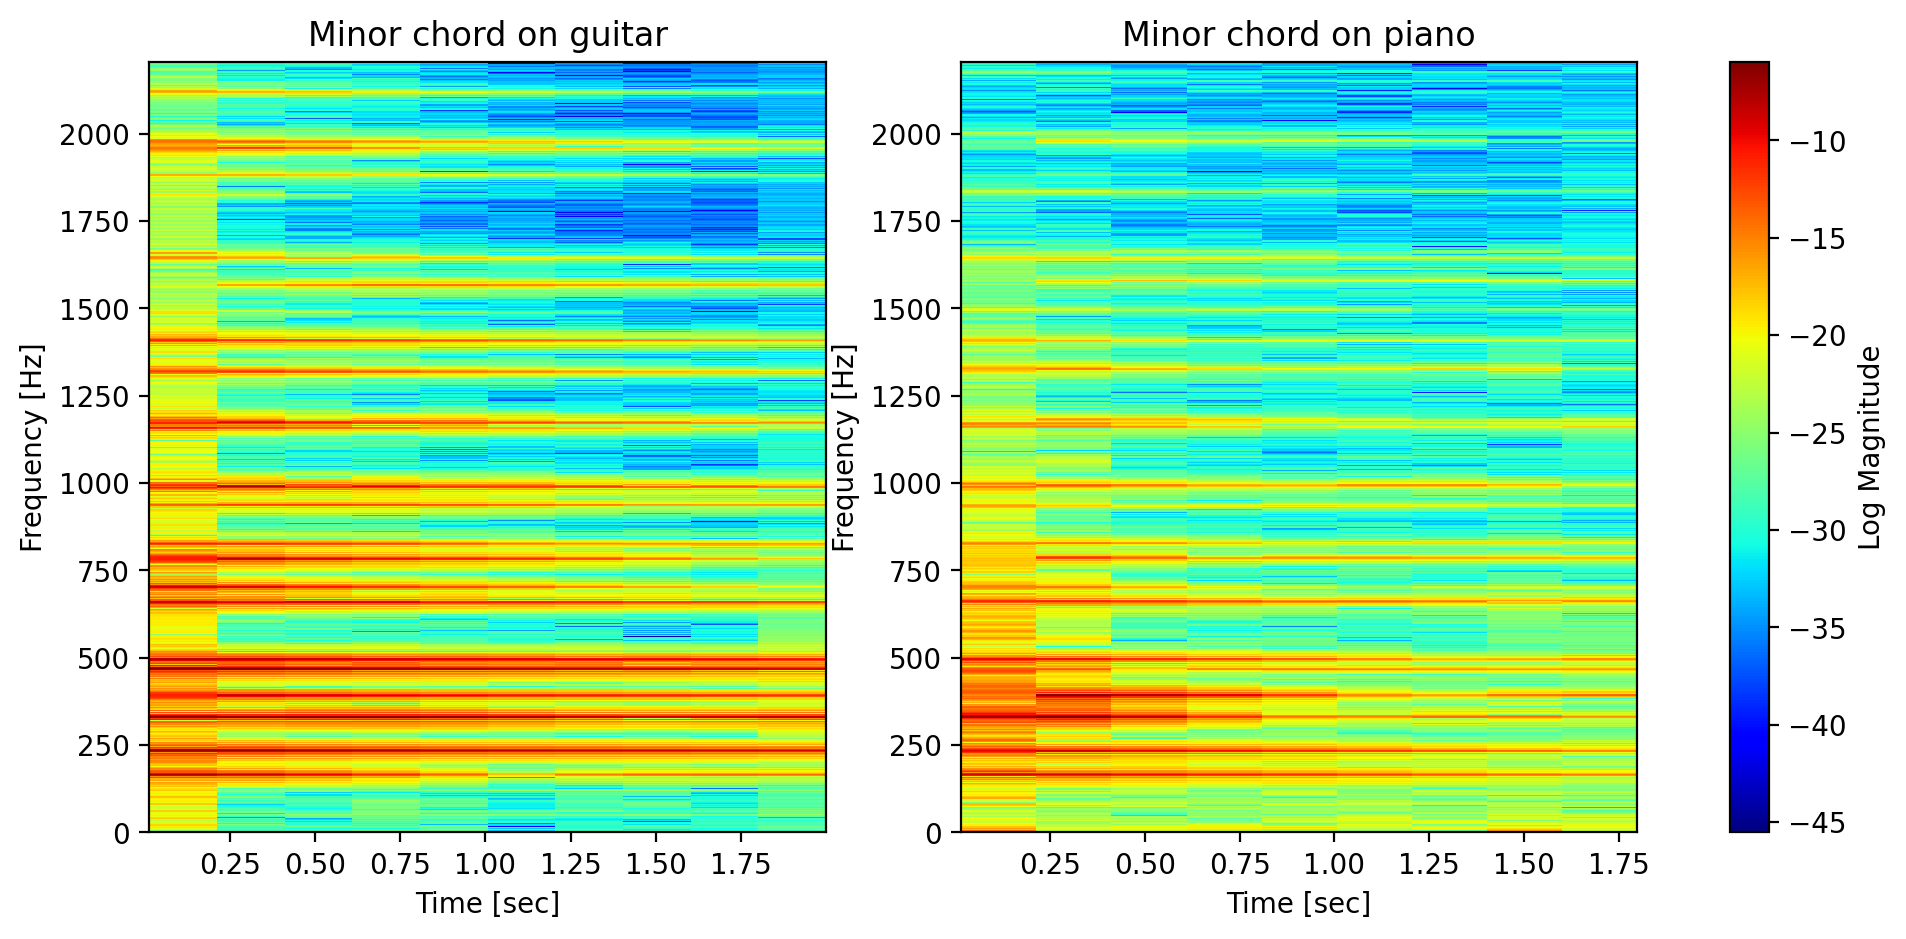

In [88]:
guitar = df.iloc[-2]["trimmed_y"]
piano = df.iloc[-1]["trimmed_y"]
fs = df.loc[0, "sample_rate"]

f_g, t_g, Sxx_g = spectrogram(guitar, fs, nperseg=10000, nfft = 50000)
f_p, t_p, Sxx_p = spectrogram(piano, fs, nperseg=10000, nfft = 50000)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].pcolormesh(t_g, f_g[:2500], np.log(Sxx_g)[:2500], cmap="jet")
axes[0].set_title("Minor chord on guitar")
axes[0].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
axes[1].pcolormesh(t_p, f_p[:2500], np.log(Sxx_p[:2500]), cmap="jet")
axes[1].set_title("Minor chord on piano")
axes[1].set(xlabel='Time [sec]', ylabel='Frequency [Hz]')
cbar = fig.colorbar(pcm1, ax=axes, label='Log Magnitude')

plt.show()

In [89]:
# Piano
ipd.Audio(df.iloc[-1]["trimmed_y"], rate=sr) # C 9

In [90]:
# guitar
ipd.Audio(df.iloc[-2]["trimmed_y"], rate=sr) # C 9

You can clearly see and hear a difference between the instruments. The guitar recordings have more overtones than the piano recordings and therefore the guitar has a broader upper frequency spectrum than the piano while the piano is slightly more present in the lower frequency range (< 250Hz).